# DESI DR7.1 FIBERASSIGN ANALYSIS

* Reads the data generated by JFR.

In [2]:
import sys
import os
import shutil
import glob
import numpy as np
import warnings
import subprocess
import matplotlib
import matplotlib.pyplot as pl
from   matplotlib.patches import Circle, Polygon, RegularPolygon
%matplotlib inline

from desitarget.cuts import select_targets, qso_selection_options

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", module='desitarget')
    # Tries to set mpl backend
    from desitarget.QA import _parse_tcnames

from desiutil.log import get_logger

from importlib import reload

add_sys_path = list()
add_sys_path.append(os.path.join(os.getcwd(),'py'))

WITH_SPHERICAL_GEOMETRY = True
if WITH_SPHERICAL_GEOMETRY:
    add_sys_path.append(os.path.join(os.environ['HOME'],
                                 'software/modules/spherical_geometry/master/lib/python3.6/site-packages/spherical_geometry-1.2.5-py3.6-linux-x86_64.egg/'))

for _ in add_sys_path:
    if _ not in sys.path:
        sys.path.append(_)
                    
from apcsv.astropy_backports import *

if WITH_SPHERICAL_GEOMETRY:
    import spherical_geometry
    from spherical_geometry import polygon as spoly

import astropy
import astropy.units as u
import astropy.coordinates as coord
import regions
from   astropy.io import fits
from   astropy.table import Table, Column

import desiutil
import desiutil.plots
import desimodel
import desimodel.focalplane
import desitarget

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning, module="matplotlib")
    # Tries to set mpl backend
    import desitarget
import desitarget.io as io
import desitarget.mtl

import desitarget.targetmask
from   desitarget.targetmask import desi_mask, bgs_mask, mws_mask, obsmask, obsconditions

import fitsio

# Helpful function to deal with multiple warnings
def warning_summary(W):
    if len(W) == 0:
        print('No warnings')
        return
    
    import collections
    d = collections.defaultdict(lambda: 0)
    for _ in W: d[_.category.__name__] += 1
        
    print('{:15s} {:s}'.format('WARNING','COUNT'))
    for k,v in d.items():
        print('{:15s} {:d}'.format(k,v))

# Print some debug info
!date
for m in [astropy,np]:
    print('{:15s} {:20s}'.format(m.__name__,m.version.version))
for m in [desitarget,desimodel]:
    print('{:15s} {:20s}'.format(m.__name__,m._version.__version__))
!echo 'fiberassign    ' $(fiberassign_exec --version)   

print()
print('Path to fiberassign_exec:')
!which fiberassign_exec

print()
print('Working dir:', os.getcwd())

print()
print('Useful numbers:')
R_TILE = desimodel.focalplane.get_tile_radius_deg()
A_TILE = np.pi*R_TILE**2
print('Tile radius: {:4.3f} deg'.format(R_TILE))
print('Tile area:   {:4.3f} sq.deg.'.format(A_TILE))

Sun Mar 24 21:40:34 PDT 2019
astropy         2.0.7               
numpy           1.13.3              
desitarget      0.29.0.dev2996      
desimodel       0.9.10.dev477       
fiberassign     0.11.1.dev2271

Path to fiberassign_exec:
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/fiberassign/master/bin/fiberassign_exec

Working dir: /global/u1/a/apcooper/projects/mws_svplan

Useful numbers:
Tile radius: 1.627 deg
Tile area:   8.321 sq.deg.


In [3]:
import fitsio
from apcsv import fiberqa
reload(fiberqa)

BLUE FAINT not defined in current targetmask
RED FAINT not defined in current targetmask
BLUE FAINT & WD not defined in current targetmask
RED FAINT & WD not defined in current targetmask


<module 'apcsv.fiberqa' from '/global/u1/a/apcooper/projects/mws_svplan/py/apcsv/fiberqa.py'>

Read JFR's data

In [4]:
bright_tiles_path = '/global/project/projectdirs/desi/www/users/forero/DR7.1fiberassign/input_tiles_bright.fits'

In [5]:
bright_tiles = Table.read(bright_tiles_path)

In [6]:
bright_tiles[0:1]

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32
28814,340.41,19.99,5,1,0.0472196,1.05143,3310.55,1.41905,BRIGHT,4


In [67]:
import desiutil

In [68]:
import desimodel.footprint as footprint

In [69]:
all_tiles = footprint.load_tiles()

chararray(['DARK', 'DARK', 'DARK', ..., 'BRIGHT', 'BRIGHT', 'BRIGHT'],
          dtype='<U6')

6028

In [7]:
TILEDIR = "/global/project/projectdirs/desi/www/users/forero/DR7.1fiberassign/bright/"

In [8]:
!ls -l $TILEDIR/tile* |head

-rw-r-----+ 1 forero desi 6877440 Mar 20 12:17 /global/project/projectdirs/desi/www/users/forero/DR7.1fiberassign/bright//tile-028814.fits
-rw-r-----+ 1 forero desi 8130240 Mar 20 12:17 /global/project/projectdirs/desi/www/users/forero/DR7.1fiberassign/bright//tile-028815.fits
-rw-r-----+ 1 forero desi 7568640 Mar 20 12:17 /global/project/projectdirs/desi/www/users/forero/DR7.1fiberassign/bright//tile-028816.fits
-rw-r-----+ 1 forero desi 7502400 Mar 20 12:17 /global/project/projectdirs/desi/www/users/forero/DR7.1fiberassign/bright//tile-028817.fits
-rw-r-----+ 1 forero desi 7845120 Mar 20 12:17 /global/project/projectdirs/desi/www/users/forero/DR7.1fiberassign/bright//tile-028818.fits
-rw-r-----+ 1 forero desi 7606080 Mar 20 12:17 /global/project/projectdirs/desi/www/users/forero/DR7.1fiberassign/bright//tile-028819.fits
-rw-r-----+ 1 forero desi 7614720 Mar 20 12:17 /global/project/projectdirs/desi/www/users/forero/DR7.1fiberassign/bright//tile-028820.fits
-rw-r-----+ 1 forero desi 7

In [9]:
# How many tile files?
!ls -l $TILEDIR/tile*.fits |wc -l

4381


In [10]:
# How much data?
!du -sh $TILEDIR

36G	/global/project/projectdirs/desi/www/users/forero/DR7.1fiberassign/bright/


In [11]:
%time hdr = fiberqa.load_fiber_headers(TILEDIR)

Have 4381 tiles
CPU times: user 20.1 s, sys: 13.4 s, total: 33.5 s
Wall time: 2min 25s


In [12]:
hdr[list(hdr.keys())[0]]


SIMPLE  =                    T / file does conform to FITS standard
BITPIX  =                   16 / number of bits per data pixel
NAXIS   =                    0 / number of data axes
EXTEND  =                    T / FITS dataset may contain extensions
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H
EXTNAME = 'PRIMARY '
TILEID  =                44175
TILERA  =               128.38
TILEDEC =                 5.94
REQRA   =               128.38
REQDEC  =                 5.94
FIELDNUM=                    0
FBAVER  = '1.0.0.dev2366'

In [13]:
# FTARGETS extension is direct from fiberassign -- fewer columns than FIBERASSIGN extension.
%time fibdata = fiberqa.load_fiber_data_lean(TILEDIR,['FIBERASSIGN','POTENTIAL_ASSIGNMENTS'])

Have 4381 tiles
CPU times: user 42.8 s, sys: 30.2 s, total: 1min 13s
Wall time: 3min 7s


In [14]:
fib_all = fibdata['FIBERASSIGN']
pot_all = fibdata['POTENTIAL_ASSIGNMENTS']

In [15]:
Table(fib_all[list(fib_all.keys())[0]])[0:3]

FIBER,LOCATION,NUMTARGET,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,TARGET_RA,TARGET_DEC,DESIGN_X,DESIGN_Y,BRICKNAME,FIBERSTATUS,DESIGN_Q,DESIGN_S,LAMBDA_REF,OBJTYPE,PETAL_LOC,DEVICE_LOC,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,BRIGHTSTARINBLOB,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,APFLUX_G [2],APFLUX_R [2],APFLUX_Z [2],APFLUX_IVAR_G [2],APFLUX_IVAR_R [2],APFLUX_IVAR_Z [2]
int32,int32,int16,int64,int64,int64,int64,float64,float64,float32,float32,bytes8,int32,float32,float32,float32,bytes3,int16,int32,int32,float64,int32,int32,int32,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,bool,bytes1,int64,int64,int64,float32,float32,float32,float32,float32,float32
0,95,-21824,607248592435937337,4294967296,0,0,128.39701089,5.2193184735,-4.154,-176.716,1284p052,0,268.653,176.808,5400.0,SKY,0,95,0,0.0,65535,0,7000,361098,57,am,6.08535e-28,2.73245e+20,9.50836e-30 .. 5.95575e-39,2.73283e+20,1.13238e-36,2.73243e+20,1.76935e-38,2.73279e+20,1.76935e-38,2.73279e+20,1.76935e-38,2.73279e+20,1.76935e-38,2.73281e+20,5.92443e-31,2.73246e+20,2.36977e-30,2.73243e+20,5.92443e-31,2.73244e+20,9.47909e-30,2.73245e+20,9.47909e-30,2.73244e+20,2.36977e-30,24941,63,64,46.5951,6.13893e-34,46.5951,6.47265e-34,-1.29746e+16,7.5306e-39,46.5951,9.19261e-39,-1.29745e+16,0,0,0,0.0,0.0,0.0,1.10703e-43,1.44115e+17,0.0,0.0,0.0,1.73841e-38,-1.08893e+20,9.0072e+15,0.0,0.0,0.0,6.10675e-39,5.3343e+13,-0.632919,2.3422e-38,1.54143e-43,2.26571e-36,2.73242e+20,0.0,1.14794e-41,0.0,5.60519e-45,0.0,303791034774,2.38796e-06,-1.04135e+26,-1.99492e+08,0.000163328,1.69571e-36,6.66566e-10,4.10282e-08,False,6.65757e-41,3.00986,6.9279e-13,-1.0954e-14,2.25058e+12,8.96831e-44,True,,0,0,21975,-0.016655 .. -0.0321015,-0.024919 .. -0.0183067,0.0343885 .. 0.0528886,774.682 .. 435.538,844.664 .. 474.263,114.457 .. 64.3396
1,62,0,30787840132516747,1152921504606846976,65793,0,128.571975314,5.31807889854,-46.7979,-152.25,1284p052,0,252.914,159.311,5400.0,TGT,0,62,2000,0.91973127926,7,0,7000,361098,2955,EXP,1.14625e+11,2.6154e+11,9287.68 .. 13182.0,0.0292518,5.53011,9.60034,13.9403,9.96375,7.02594,-5.96951,780.96,85.3396,100.056,13.6603,2.6649,0.466281,0.000832054,2.01941e-05,0.917052,0.943339,0.9679,0.995055,0.99696,0.999351,0.999755,1,2,2,-4.939e-05,0.000143641,0.00255494,0.00470552,0.00706009

In [16]:
Table(fib_all[list(fib_all.keys())[1]])[0:3]

FIBER,LOCATION,NUMTARGET,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,TARGET_RA,TARGET_DEC,DESIGN_X,DESIGN_Y,BRICKNAME,FIBERSTATUS,DESIGN_Q,DESIGN_S,LAMBDA_REF,OBJTYPE,PETAL_LOC,DEVICE_LOC,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,BRIGHTSTARINBLOB,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,APFLUX_G [2],APFLUX_R [2],APFLUX_Z [2],APFLUX_IVAR_G [2],APFLUX_IVAR_R [2],APFLUX_IVAR_Z [2]
int32,int32,int16,int64,int64,int64,int64,float64,float64,float32,float32,bytes8,int32,float32,float32,float32,bytes3,int16,int32,int32,float64,int32,int32,int32,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,bool,bytes1,int64,int64,int64,float32,float32,float32,float32,float32,float32
0,95,0,30787621688970675,2305843009213693952,0,14336,61.0690392057,-3.68067066011,-7.10284,-171.731,0609m037,0,267.632,171.917,5400.0,TGT,0,95,1500,0.765995434971,7,0,7000,309017,3507,PSF,1.44955e+14,1.80192e+14,159738.0 .. 0.0,0.0956987,10.2531,22.114,31.9778,13.1717,5.85457,-13.991,368.721,290.502,62.2879,96.5669,2.80542,0.556553,0.000937431,1.91756e-05,0.753303,0.826276,0.89876,0.983913,0.990089,0.997878,0.999198,1,1,3,9.58357e-05,7.02772e-05,0.000148253,0.0747033,0.0222113,0.0140438,0.996981,0.996112,0.997247,0,0,0,886.49,196.382,163.671,520.02,109.903,79.5695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.98346,17.2188,24.8991,7.98346,17.2188,24.8991,3251913322567661440,19.3233,229.972,19.8141,25.0997,18.628,37.7101,0.0,False,0.300719,5.1776,1.85882,3.12493,0.304389,4.20626,False,S,1500,1,23106,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0
1,62,0,30787627724571122,2305843009213693952,0,1792,61.219912527,-3.60133531625,-43.9564,-152.106,0612m035,0,253.882,158.361,5400.0,TGT,0,62,1500,0.230017674305,7,0,7000,310456,498,PSF,1.12261e+15,2.21474e+15,2.44938e+06 .. 0.0,0.108108,52.9904,105.812,149.022,57.8014,30.1425,2.45751,-584.599,196.748,40.6141,64.9492,2.79907,0.568779,0.00102529,2.11501e-05,0.726134,0.806081,0.886406,0.981846,0.988812,0.997603,0.999094,2,2,4,3.34519e-06,2.66892e-06,3.6053e-06,0.00397267,0.00446993,0.0130128,0.999192,0.998994,0.998965,0,0,0,1935.99,428.07,234.723,1117.45,232.304,118.288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.2557,82.3801,116.021,41.2558,82.3807,116.022,3251938718710900608,17.5638,818.3

In [17]:
t   = fiberqa.tile_dict_to_table(fib_all)
pot = fiberqa.tile_dict_to_table(pot_all)
print(len(t), len(pot))

21905000 179116595


In [18]:
len(t)

21905000

In [19]:
utid, utid_c = np.unique(t['TARGETID'],return_counts=True)

In [20]:
np.sum(utid_c[utid_c == 1]), np.sum(utid_c[utid_c > 1])

(20256402, 1648598)

In [21]:
nutid_desi, nutid_c = np.unique(t['DESI_TARGET'][np.isin(t['TARGETID'],utid[utid_c > 1])],return_counts=True)

In [22]:
_s = np.argsort(nutid_c)
for __s in _s:
    print("{:20d} {:8d} {:s}".format(nutid_desi[__s],nutid_c[__s],','.join(desi_mask.names(nutid_desi[__s]))))

 2305843034983497728        2 STD_FAINT,STD_WD,MWS_ANY
 1152921538966585344        2 STD_BRIGHT,BGS_ANY
 2305843026662064137        2 LRG,LRG_1PASS,LRG_SOUTH,LRG_1PASS_SOUTH,STD_WD,MWS_ANY
 2305843026410340608        2 LRG_NORTH,LRG_1PASS_NORTH,STD_WD,MWS_ANY
 3458764556770476036        2 QSO,QSO_SOUTH,STD_FAINT,STD_BRIGHT,BGS_ANY,MWS_ANY
 2305843043573432320        3 STD_BRIGHT,MWS_ANY
 2305843009482458125        3 LRG,QSO,LRG_1PASS,QSO_NORTH,LRG_SOUTH,QSO_SOUTH,LRG_1PASS_SOUTH,MWS_ANY
 2305843009499235597        3 LRG,QSO,LRG_1PASS,LRG_NORTH,QSO_NORTH,LRG_SOUTH,QSO_SOUTH,LRG_1PASS_NORTH,LRG_1PASS_SOUTH,MWS_ANY
 3458764556770214912        4 QSO_NORTH,STD_FAINT,STD_BRIGHT,BGS_ANY,MWS_ANY
 1152921547556519936        4 STD_FAINT,STD_BRIGHT,BGS_ANY
 3458764556770477060        6 QSO,QSO_NORTH,QSO_SOUTH,STD_FAINT,STD_BRIGHT,BGS_ANY,MWS_ANY
 2305843026393564160        9 QSO_NORTH,STD_WD,MWS_ANY
 2305843017803629568       16 QSO_NORTH,STD_FAINT,MWS_ANY
 2305843052163630084       21 QSO,QSO_NO

In [23]:
utile = np.unique(t['ITILE'])

In [24]:
len(utile)

4381

In [25]:
t[5000:5005]

FIBER,LOCATION,NUMTARGET,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,TARGET_RA,TARGET_DEC,DESIGN_X,DESIGN_Y,BRICKNAME,FIBERSTATUS,DESIGN_Q,DESIGN_S,LAMBDA_REF,OBJTYPE,PETAL_LOC,DEVICE_LOC,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,BRIGHTSTARINBLOB,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,APFLUX_G [2],APFLUX_R [2],APFLUX_Z [2],APFLUX_IVAR_G [2],APFLUX_IVAR_R [2],APFLUX_IVAR_Z [2],ITILE
int32,int32,int16,int64,int64,int64,int64,float64,float64,float32,float32,bytes8,int32,float32,float32,float32,bytes3,int16,int32,int32,float64,int32,int32,int32,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,bool,bytes1,int64,int64,int64,float32,float32,float32,float32,float32,float32,int64
0,95,0,30787621688970675,2305843009213693952,0,14336,61.0690392057,-3.68067066011,-7.10284,-171.731,0609m037,0,267.632,171.917,5400.0,TGT,0,95,1500,0.765995434971,7,0,7000,309017,3507,PSF,1.44955e+14,1.80192e+14,159738.0 .. 0.0,0.0956987,10.2531,22.114,31.9778,13.1717,5.85457,-13.991,368.721,290.502,62.2879,96.5669,2.80542,0.556553,0.000937431,1.91756e-05,0.753303,0.826276,0.89876,0.983913,0.990089,0.997878,0.999198,1,1,3,9.58357e-05,7.02772e-05,0.000148253,0.0747033,0.0222113,0.0140438,0.996981,0.996112,0.997247,0,0,0,886.49,196.382,163.671,520.02,109.903,79.5695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.98346,17.2188,24.8991,7.98346,17.2188,24.8991,3251913322567661440,19.3233,229.972,19.8141,25.0997,18.628,37.7101,0.0,False,0.300719,5.1776,1.85882,3.12493,0.304389,4.20626,False,S,1500,1,23106,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,38890
1,62,0,30787627724571122,2305843009213693952,0,1792,61.219912527,-3.60133531625,-43.9564,-152.106,0612m035,0,253.882,158.361,5400.0,TGT,0,62,1500,0.230017674305,7,0,7000,310456,498,PSF,1.12261e+15,2.21474e+15,2.44938e+06 .. 0.0,0.108108,52.9904,105.812,149.022,57.8014,30.1425,2.45751,-584.599,196.748,40.6141,64.9492,2.79907,0.568779,0.00102529,2.11501e-05,0.726134,0.806081,0.886406,0.981846,0.988812,0.997603,0.999094,2,2,4,3.34519e-06,2.66892e-06,3.6053e-06,0.00397267,0.00446993,0.0130128,0.999192,0.998994,0.998965,0,0,0,1935.99,428.07,234.723,1117.45,232.304,118.288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.2557,82.3801,116.021,41.2558,82.3807,116.022,325193871871090

In [26]:
# Report numbers for each raw MWS bit
print('{:10s} {:10s}'.format('MWS_TARGET','NTARGETS'))
mws_counts = np.unique(t['MWS_TARGET'],return_counts=True)
for a,b in zip(*mws_counts):
    if a > 0:
        print('{:<10d} {:<10d} {:s}'.format(a,b,' & '.join(mws_mask.names(a))))
        
print()
nmws = (t['MWS_TARGET'] > 0).sum()
print('{:,d} MWS targets; {:,d} non-MWS targets; {:,d} total'.format(nmws,len(t)-nmws,len(t)))
                                                    

MWS_TARGET NTARGETS  
2          50030      MWS_WD
4          40425      MWS_NEARBY
6          3034       MWS_WD & MWS_NEARBY
49         1612880    MWS_BROAD & MWS_BROAD_NORTH & MWS_BROAD_SOUTH
51         91         MWS_BROAD & MWS_WD & MWS_BROAD_NORTH & MWS_BROAD_SOUTH
53         11413      MWS_BROAD & MWS_NEARBY & MWS_BROAD_NORTH & MWS_BROAD_SOUTH
55         266        MWS_BROAD & MWS_WD & MWS_NEARBY & MWS_BROAD_NORTH & MWS_BROAD_SOUTH
1792       3222776    MWS_MAIN_BLUE & MWS_MAIN_BLUE_NORTH & MWS_MAIN_BLUE_SOUTH
1794       14671      MWS_WD & MWS_MAIN_BLUE & MWS_MAIN_BLUE_NORTH & MWS_MAIN_BLUE_SOUTH
1796       82         MWS_NEARBY & MWS_MAIN_BLUE & MWS_MAIN_BLUE_NORTH & MWS_MAIN_BLUE_SOUTH
1798       2589       MWS_WD & MWS_NEARBY & MWS_MAIN_BLUE & MWS_MAIN_BLUE_NORTH & MWS_MAIN_BLUE_SOUTH
14336      879442     MWS_MAIN_RED & MWS_MAIN_RED_NORTH & MWS_MAIN_RED_SOUTH
14338      18         MWS_WD & MWS_MAIN_RED & MWS_MAIN_RED_NORTH & MWS_MAIN_RED_SOUTH

5,837,717 MWS targets; 16,067,

In [27]:
# Report numbers for each raw BGS bit
print('{:10s} {:10s}'.format('BGS_TARGET','NTARGETS'))
bgs_counts = np.unique(t['BGS_TARGET'],return_counts=True)
for a,b in zip(*bgs_counts):
    if a > 0:
        print('{:<10d} {:<10d} {:s}'.format(a,b,' & '.join(bgs_mask.names(a))))
        
print()
nbgs = (t['BGS_TARGET'] > 0).sum()
print('{:,d} BGS targets; {:,d} non-BGS targets; {:,d} total'.format(nbgs,len(t)-nbgs,len(t)))
                                       

BGS_TARGET NTARGETS  
65793      3830749    BGS_FAINT & BGS_FAINT_NORTH & BGS_FAINT_SOUTH
131586     6880971    BGS_BRIGHT & BGS_BRIGHT_NORTH & BGS_BRIGHT_SOUTH
263172     357767     BGS_WISE & BGS_WISE_NORTH & BGS_WISE_SOUTH

11,069,487 BGS targets; 10,835,513 non-BGS targets; 21,905,000 total


In [28]:
# Report numbers for each priority
print('{:10s} {:10s}'.format('PRIORITY','NTARGETS'))
for a,b in reversed(list(zip(*np.unique(t['PRIORITY'],return_counts=True)))):
    print('{:<10d} {:<10d}'.format(a,b))

PRIORITY   NTARGETS  
3400       328038    
3200       812426    
2998       69057     
2100       6584063   
2000       3369165   
1600       51896     
1500       3992661   
1400       1605792   
0          5091902   


In [79]:
# Report numbers for each raw DESI bit, including overlaps
is_mws = t['MWS_TARGET'] > 0 
is_bgs = t['BGS_TARGET'] > 0 

# This area doesn't account for overlap!
ntiles = len(hdr)
print('Total area in trial: {} sq. deg.'.format(ntiles*A_TILE))
print()

total_bright_tiles = (all_tiles['IN_DESI'] & (all_tiles['PROGRAM'] == 'BRIGHT')).sum()
print('Total area in survey: {} sq. deg.'.format(total_bright_tiles*A_TILE))
print()

trial_area_fraction = ntiles/float(total_bright_tiles)
print('Fraction of survey area in trial: {:5.3f}'.format(trial_area_fraction))
print()

# DENS column is not useful here, since area doesn't account for overlap.
for (class_name, class_sel) in [('MWS',is_mws),
                                ('BGS',is_bgs),
                                ('OTHER',(~(is_mws | is_bgs))),
                               ]:
    
    print('{} targets'.format(class_name))
    print('{:20s} {:>10s} {:10s} {:10s}'.format('DESI_TARGET','NFIBERS','DENS','CLASSES'))
    
    u_targetids, u_counts = np.unique(t['DESI_TARGET'][class_sel],return_counts=True)
    approx_density        = u_counts/A_TILE/ntiles
    
    for tid,count,dens in zip(u_targetids,u_counts,approx_density):
        cstr = ' & '.join(desi_mask.names(tid))
        cstr = cstr.replace('NORTH','N')
        cstr = cstr.replace('SOUTH','S')
        if len(cstr) > 80:
            cstr = cstr[0:77] + '...'
        else:
            cstr = cstr[0:80]
        print('{:<20d} {:>10d} {:<10.2f} {:10s}'.format(tid,count,dens,cstr))
    print()

Total area in trial: 36454.825276023344 sq. deg.

Total area in survey: 50159.709373172496 sq. deg.

Fraction of survey area in trial: 0.727

MWS targets
DESI_TARGET             NFIBERS DENS       CLASSES   
2305843009213693952     5097298 139.83     MWS_ANY   
2305843009213694976        1111 0.03       QSO_N & MWS_ANY
2305843009213956100         117 0.00       QSO & QSO_S & MWS_ANY
2305843009213957124       26110 0.72       QSO & QSO_N & QSO_S & MWS_ANY
2305843009230471424           6 0.00       LRG_N & LRG_1PASS_N & MWS_ANY
2305843009482194953          12 0.00       LRG & LRG_1PASS & LRG_S & LRG_1PASS_S & MWS_ANY
2305843009482195977           1 0.00       LRG & LRG_1PASS & QSO_N & LRG_S & LRG_1PASS_S & MWS_ANY
2305843009482458125           3 0.00       LRG & QSO & LRG_1PASS & QSO_N & LRG_S & QSO_S & LRG_1PASS_S & MWS_ANY
2305843009498972425           9 0.00       LRG & LRG_1PASS & LRG_N & LRG_S & LRG_1PASS_N & LRG_1PASS_S & MWS_ANY
2305843009498973449           1 0.00       LRG & LRG

In [30]:
from astropy import coordinates as coord

In [31]:
tra = list()
tde = list()
tid = list()
for k,h in hdr.items():
    tid.append(k)
    tra.append(h['TILERA'])
    tde.append(h['TILEDEC'])
tid = np.array(tid)

In [32]:
c = coord.SkyCoord(tra,tde,unit='deg')

In [33]:
X = coord.SkyCoord([165],[10],unit='deg')
target_tid = tid[c.separation(X) < 10*u.deg]

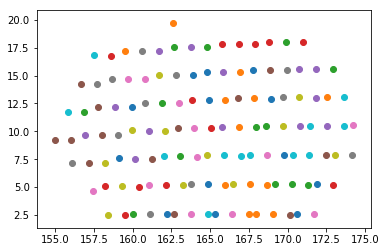

In [34]:
for k in target_tid:
    pl.scatter(hdr[k]['TILERA'],hdr[k]['TILEDEC'])

(160, 165)

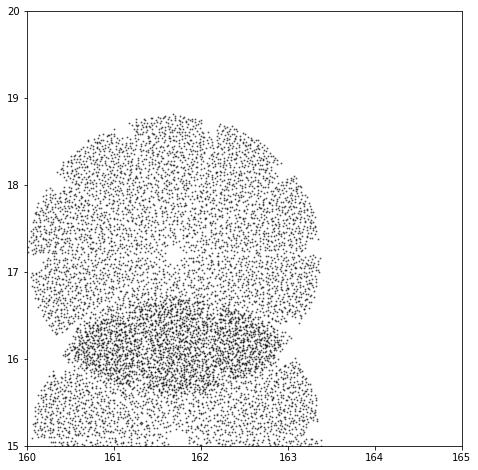

In [35]:
# Sky plot -- all fibers
pl.figure(figsize=(15,8))
for k in target_tid[0:20]:
    s = t['ITILE'] == k
    pl.scatter(t['TARGET_RA'][s],
               t['TARGET_DEC'][s],c='k',s=1,alpha=0.5)
pl.axis('scaled')
pl.ylim(15,20)
pl.xlim(160,165)

(-25, 40)

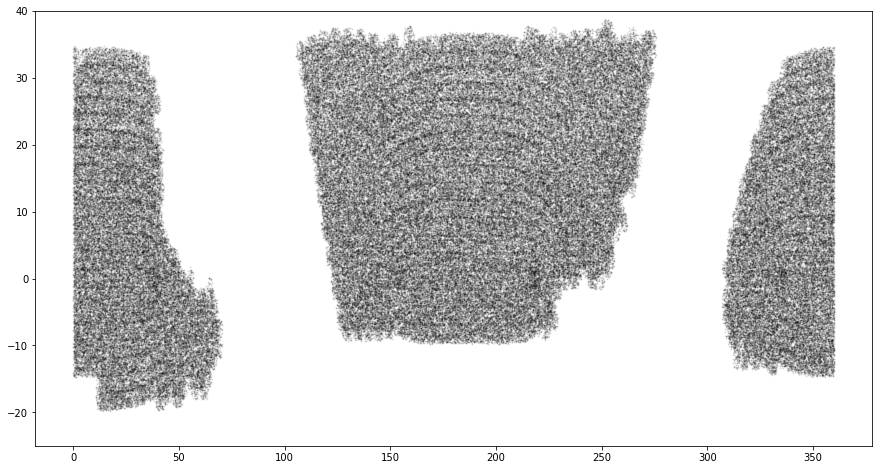

In [36]:
# Sky plot -- all fibers
pl.figure(figsize=(15,8))
r = np.argsort(np.random.random(len(t)))
s = np.arange(0,len(t))[r[::100]]
pl.scatter(t['TARGET_RA'][s],
           t['TARGET_DEC'][s],c='k',s=1,alpha=0.1)
pl.ylim(-25,40)
#pl.axis('equal')

Fractions of target pool observed requires MTL.

In [37]:
ls /global/project/projectdirs/desi/www/users/forero/DR7.1fiberassign/

bright/  input_tiles_bright.fits  mtl_dr7.1-0.27.0.fits
dark/    input_tiles_dark.fits


In [38]:
input_path = '/global/project/projectdirs/desi/www/users/forero/DR7.1fiberassign/'
!ls -lh $input_path

total 28G
drwxrws---+ 2 forero desi 512K Mar 20 12:22 bright
drwxrws---+ 2 forero desi 1.0M Mar 20 12:13 dark
-rw-rw----+ 1 forero desi 301K Mar 18 16:11 input_tiles_bright.fits
-rw-rw----+ 1 forero desi 498K Mar 18 16:11 input_tiles_dark.fits
-rw-rw----+ 1 forero desi  28G Mar 20 12:39 mtl_dr7.1-0.27.0.fits


In [39]:
targets_path = '/global/project/projectdirs/desi/www/users/forero/DR7.1fiberassign/mtl_dr7.1-0.27.0.fits'
!ls -lh $targets_path

-rw-rw----+ 1 forero desi 28G Mar 20 12:39 /global/project/projectdirs/desi/www/users/forero/DR7.1fiberassign/mtl_dr7.1-0.27.0.fits


In [40]:
targets = fitsio.read(targets_path,columns=['TARGETID','DESI_TARGET','MWS_TARGET'])

In [41]:
avail_ids = np.sort(pot['TARGETID'])

In [84]:
print('{:10s} {:15s} {:15s} {:15s} {:15s} {:9s}'.format('','N_MTL','N_AVAIL','DENS_AVAIL','N_OBS','N_OBS_FULL','FRAC_OBS'))
for _ in ['MWS_ANY','BGS_ANY']:
    bitmask = desi_mask.mask(_)
    
    in_mtl    = (targets['DESI_TARGET'] & bitmask) != 0
    total_mtl = in_mtl.sum()
    
    is_avail    = np.isin(targets['TARGETID'][in_mtl], avail_ids, assume_unique=True)
    total_avail = is_avail.sum()
    dens_avail  = 3*total_avail/A_TILE/ntiles
    total_obs   = np.sum(t['DESI_TARGET'] == bitmask)
    print("{:10s} {:<15,d} {:<15,d} {:<15.1f} {:<15,d} {:<15,d} {:<6.3f}".format(_,
                                                           total_mtl,
                                                           total_avail,
                                                           dens_avail,
                                                           total_obs,
                                                           int(total_obs/trial_area_fraction),
                                                           float(total_obs)/total_avail))

           N_MTL           N_AVAIL         DENS_AVAIL      N_OBS           N_OBS_FULL
MWS_ANY    17,461,845      16,321,123      1343.1          5,097,298       7,013,584       0.312 
BGS_ANY    13,634,618      13,274,928      1092.4          9,909,297       13,634,613      0.746 


In [50]:
with warnings.catch_warnings(record=True) as W:
    #warnings.filterwarnings("ignore",category=RuntimeWarning)
    g = -2.5*np.log10(t['FLUX_G'])+22.5
    r = -2.5*np.log10(t['FLUX_R'])+22.5
warning_summary(W)
    
is_mws    = t['MWS_TARGET'] != 0
is_bgs    = t['BGS_TARGET'] != 0 
is_nearby = t['MWS_TARGET'] & mws_mask['MWS_NEARBY'] != 0 
is_wd     = t['MWS_TARGET'] & mws_mask['MWS_WD'] != 0 
is_main   = is_mws & ~(is_wd|is_nearby)


WARNING         COUNT
RuntimeWarning  4


WARNING         COUNT
RuntimeWarning  1
WARNING         COUNT
RuntimeWarning  1
WARNING         COUNT
RuntimeWarning  2


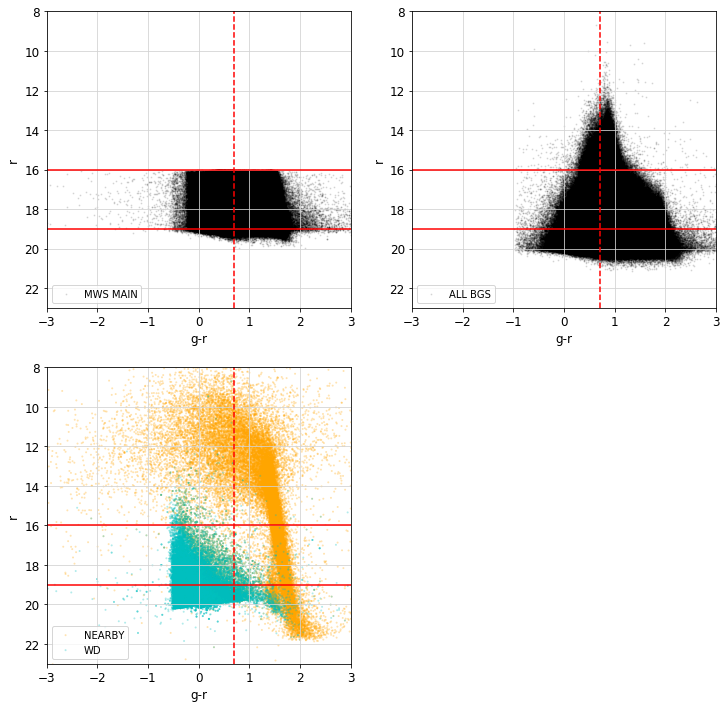

In [62]:
# Colour-magnitude of observed targets
pl.figure(figsize=(12,12))

# All MWS Main
ax = pl.subplot(221)
with warnings.catch_warnings(record=True) as W:
    pl.scatter((g-r)[is_main], r[is_main]
               ,s=1,alpha=0.1,c='k',label='MWS MAIN')
#    pl.scatter((g-r)[is_bgs & is_main],r[is_bgs & is_main], 
#               s=70, alpha=0.3,facecolor='None',edgecolor='g',marker='o',zorder=-10,label='BGS Overlap')
warning_summary(W)

pl.xlabel('g-r',fontsize=12)
pl.ylabel('r',fontsize=12)
pl.axhline(19,c='r')
pl.axhline(16,c='r')
pl.axvline(0.7,c='r',ls='--') # RED/BLUE separation
pl.ylim(23,8)
pl.grid(c='lightgrey')

ax = pl.gca()
pl.tick_params(labelsize=12)
pl.xlim(-3,3)
pl.legend(loc='lower left')

ax = pl.subplot(222)
with warnings.catch_warnings(record=True) as W:
    pl.scatter((g-r)[is_bgs],r[is_bgs],s=1,
               alpha=0.1,c='k',label='ALL BGS')
warning_summary(W)

pl.xlabel('g-r',fontsize=12)
pl.ylabel('r',fontsize=12)
pl.axhline(19,c='r')
pl.axhline(16,c='r')
pl.axvline(0.7,c='r',ls='--') # RED/BLUE separation
pl.ylim(23,8)
pl.grid(c='lightgrey')

ax = pl.gca()
pl.tick_params(labelsize=12)
pl.xlim(-3,3)
pl.legend(loc='lower left')

ax = pl.subplot(223)
with warnings.catch_warnings(record=True) as W:
    pl.scatter((g-r)[is_nearby],r[is_nearby], 
               s=1, facecolor='None',edgecolor='orange',label='NEARBY',alpha=0.3)
    pl.scatter((g-r)[is_wd],r[is_wd], 
               s=1, facecolor='None',edgecolor='c',label='WD',alpha=0.3)
#    pl.scatter((g-r)[is_bgs & (is_wd|is_nearby)],r[is_bgs & (is_wd|is_nearby)], 
#           s=70, alpha=0.3,facecolor='None',edgecolor='g',marker='o',zorder=-10,label='BGS Overlap')
warning_summary(W)
 
pl.xlabel('g-r',fontsize=12)
pl.ylabel('r',fontsize=12)
pl.axhline(19,c='r')
pl.axhline(16,c='r')
pl.axvline(0.7,c='r',ls='--') # RED/BLUE separation
pl.ylim(23,8)
pl.grid(c='lightgrey')

ax = pl.gca()
pl.tick_params(labelsize=12)
pl.xlim(-3,3)
pl.legend(loc='lower left')